In [294]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pandas as pd
%matplotlib inline
import statsmodels.api as sm
import random

In [295]:
def run_f(fit):
    A = np.identity(len(fit.params))
    A = A[1:,:]
    return fit.f_test(A).pvalue

In [272]:
def log_transform(outcome, predictors):
    model_log = sm.regression.linear_model.OLS(np.log(outcome),predictors)
    fit_log= model_log.fit()
    if any(fit_log.pvalues <.05):
        return True, 'log_y'

    else:
        return False, False

    
    
def add_dummy(outcome, predictors):
    model_dummy = sm.regression.linear_model.OLS(outcome,
                                                 np.vstack([dummy,
                                                            predictors[:,0], 
                                                            predictors[:,1], 
                                                            predictors[:,2]]).T)
    fit_dummy= model_dummy.fit()
    if any(fit_dummy.pvalues[1:] < .05) & (run_f(fit_dummy) < .05):
        return True, 'Dummy'

    else:
        return False, False

def interactions_1(outcome, predictors):
        #Check for a first interaction
    add_interaction = sm.regression.linear_model.OLS(outcome,
                                                 np.vstack([predictors[:,0]*predictors[:,1],
                                                            predictors[:,0], 
                                                            predictors[:,1], 
                                                            predictors[:,2]]).T)
    fit_interaction= add_interaction.fit()
    if any(fit_interaction.pvalues< .05) & (run_f(fit_interaction) < .05):
        return True, 'Interaction'
    else:
        return False,False

def interactions_2(outcome,predictors):

    #Check for a second interaction
    add_interaction = sm.regression.linear_model.OLS(outcome,
                                                 np.vstack([predictors[:,1]*predictors[:,2],
                                                            predictors[:,0], 
                                                            predictors[:,1], 
                                                            predictors[:,2]]).T)
    fit_interaction= add_interaction.fit()
    if any(fit_interaction.pvalues< .05) & (run_f(fit_interaction) < .05):
        return True, 'Interaction'
    else:
        return False,False
    
def interactions_3(outcome, predictors):

    #Check for a third interaction
    add_interaction = sm.regression.linear_model.OLS(outcome,
                                                 np.vstack([predictors[:,0]*predictors[:,2],
                                                            predictors[:,0], 
                                                            predictors[:,1], 
                                                            predictors[:,2]]).T)
    fit_interaction= add_interaction.fit()
    if any(fit_interaction.pvalues< .05) & (run_f(fit_interaction) < .05):
        return True, 'Interaction'

    else:
        return False, False

def outlier_removal(outcome, predictors):
    outliers = np.where(sm.regression.linear_model.OLSResults.outlier_test(fit)<.05)
    predictors_or = np.delete(predictors, outliers,axis=0)

    outcome_or = np.delete(outcome, outliers,axis=0)
    model_or = sm.regression.linear_model.OLS(outcome_or,predictors_or)
    fit_or= model_or.fit()


    if any(fit_or.pvalues < .05) & (run_f(fit_or) < .05):
        return True, 'Outliers Removed'
    else:
        return False,False
    
def directional_test(outcome, predictors):
    model = sm.regression.linear_model.OLS(outcome,predictors)
    fit= model.fit()
    if any(fit.pvalues < .1) & (run_f(fit) < .05):
        return True, 'Base'
    else:
        return False,False
    
def marginally_significant(outcome, predictors):
    model = sm.regression.linear_model.OLS(outcome,predictors)
    fit= model.fit()
    if any(fit.pvalues < .1) & (run_f(fit) < .1):
        return True, 'Base'
    else:
        return False, False

In [273]:
def analysis(adjust=False):
    N = 1000
    outcome = np.random.gamma(5,1,N)
    predictors = np.random.normal(0,1,size=(N,3))
    dummy = np.random.binomial(1,.5,N)
    model = sm.regression.linear_model.OLS(outcome,predictors)
    fit= model.fit()
    
    
    
    if any(fit.pvalues < .05) & (run_f(fit) < .05):
        return True, 'Base', 0
    
    if adjust:
        attempts = [outlier_removal, 
                   interactions_1,
                   interactions_2,
                   interactions_3,
                   add_dummy,
                   log_transform,
                   directional_test,
                   marginally_significant]
        random.shuffle(attempts)
        count = 0
        for item in attempts:
            output = item(outcome,predictors)
            count+=1
            if output[0]:
                return output[0], output[1], count
    

    
    
    return False, 'None', 0

In [298]:
processes = []
tries = []
sigs = []

for idx in range(5000):
    sig, process,count = analysis()
    if sig:
        false_pos += 1
        
    processes.append(other)
    sigs.append(sig)
    tries.append(count)

np.mean(sigs)
control_df = pd.DataFrame({'Significant':sigs, 
              'tries':tries,
               'procces':processes})

In [299]:
print(np.mean(control_df['Significant']))
control_df.head()

0.0484


,Significant,tries,procces
0,True,0,None
1,False,0,None
2,False,0,None
3,True,0,None
4,False,0,None


In [289]:
processes = []
tries = []
sigs = []

for idx in range(5000):
    sig, process,count = analysis(adjust=True)
    if sig:
        false_pos += 1
        
    processes.append(other)
    sigs.append(sig)
    tries.append(count)

np.mean(sigs)
break_prereg_df = pd.DataFrame({'Significant':sigs, 
              'tries':tries,
               'procces':processes})

In [290]:
print(np.mean(break_prereg_df['Significant']))
break_prereg_df.head()


0.1826


,Significant,tries,procces
0,False,0,None
1,False,0,None
2,True,0,None
3,False,0,None
4,False,0,None


In [390]:
np.mean(break_prereg_df[break_prereg_df['tries']<3]['Significant'])

0.10783671687404497

In [391]:
np.mean(break_prereg_df[break_prereg_df['tries']<2]['Significant'])

0.08568232662192393

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


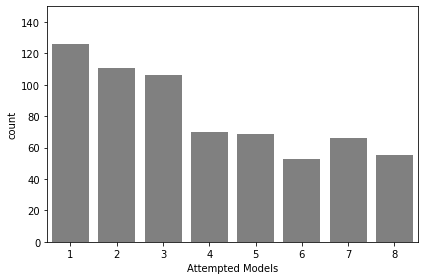

In [374]:
sns.countplot(break_prereg_df[break_prereg_df['Significant']]['tries'],color='grey')
plt.xlabel('Attempted Models')
plt.xlim(0.5,8.5)
plt.ylim(0,150)
plt.tight_layout()
plt.savefig('./for_twitter.png')

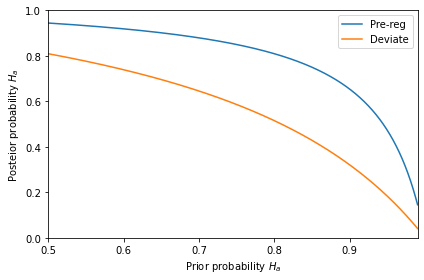

In [372]:
x=np.logspace(0,2,1000)

x_prereg = lambda x: ((1-x) * .85)/((1-x) * .85 + (x*.05))
x_violate = lambda x: ((1-x) * .85)/((1-x) * .85 + (x*.2))

plt.plot(x/(x+1), x_prereg(x/(x+1)),label='Pre-reg')
plt.plot(x/(x+1), x_violate(x/(x+1)),label='Deviate')


plt.xlabel('Prior probability $H_a$')
plt.ylabel('Posteior probability $H_a$')
plt.legend()
plt.xlim(0.5,np.max(x/(x+1)))
plt.ylim(0,1)
plt.tight_layout()
plt.savefig('./for_twitter2.png')